# 🧠 Alzheimer's Disease Classification

🕸️ A Convolutional Neural Network (CNN) model is used here to classify brain MRIs into normal, very-mild, mild and moderate Alzheimer classes. The data in total consists of 6400 images.

Developed as part of a project work for the **UCS 1603 Introduction to Machine Learning** Course. 📖

Authors:
* Shashanka Venkatesh  - 18 5001 145
* Suraj Jain           - 18 5001 177
* Vishakan Subramanian - 18 5001 196
* Vishnu Krishnan      - 18 5001 200

**We recommend the use of a GPU Accelerator to reduce the load on the CPU and to run the notebook faster.**

### Importing the necessary libraries

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.10.0


### Data Pre-Processing

In [12]:
base_dir = "AD_data/3-splitted_ADNI(6400)/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [13]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [14]:
#Performing Image Augmentation to have more data samples
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


In [15]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    

In [16]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [17]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [18]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

NameError: name 'SMOTE' is not defined

In [19]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Using the InceptionV3 model as a base model for the task

In [14]:
inception_model = InceptionV3(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [15]:
for layer in inception_model.layers:
    layer.trainable=False

In [16]:
custom_inception_model = Sequential([
        inception_model,
        Dropout(0.5),
        GlobalAveragePooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        BatchNormalization(),
        Dense(4, activation='softmax')        
    ], name = "inception_cnn_model")

In [17]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [18]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]
    
custom_inception_model.compile(optimizer='rmsprop',
                              loss=tf.losses.CategoricalCrossentropy(),
                              metrics=METRICS)

custom_inception_model.summary()

Model: "inception_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense (Dense)               (None, 512)       

In [19]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = custom_inception_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 34s 91ms/step - loss: 1.3925 - acc: 0.4089 - auc: 0.6860 - f1_score: 0.4030 - val_loss: 0.8364 - val_acc: 0.6138 - val_auc: 0.8720 - val_f1_score: 0.5760 - lr: 0.0010
Epoch 2/100
256/256 [==============================] - 18s 72ms/step - loss: 0.9277 - acc: 0.5708 - auc: 0.8415 - f1_score: 0.5635 - val_loss: 0.6594 - val_acc: 0.6768 - val_auc: 0.9176 - val_f1_score: 0.6598 - lr: 0.0010
Epoch 3/100
256/256 [==============================] - 19s 73ms/step - loss: 0.7951 - acc: 0.6312 - auc: 0.8829 - f1_score: 0.6217 - val_loss: 0.6095 - val_acc: 0.7158 - val_auc: 0.9295 - val_f1_score: 0.7069 - lr: 0.0010
Epoch 4/100
256/256 [==============================] - 19s 73ms/step - loss: 0.7262 - acc: 0.6666 - auc: 0.9031 - f1_score: 0.6616 - val_loss: 0.5799 - val_acc: 0.7388 - val_auc: 0.9373 - val_f1_score: 0.7300 - lr: 0.0010
Epoch 5/100
256/256 [==============================] - 18s 72ms/step - loss: 0.6877 - acc: 0.6887 - auc: 0.9128 

### Tabulating the Results of our custom InceptionV3 model

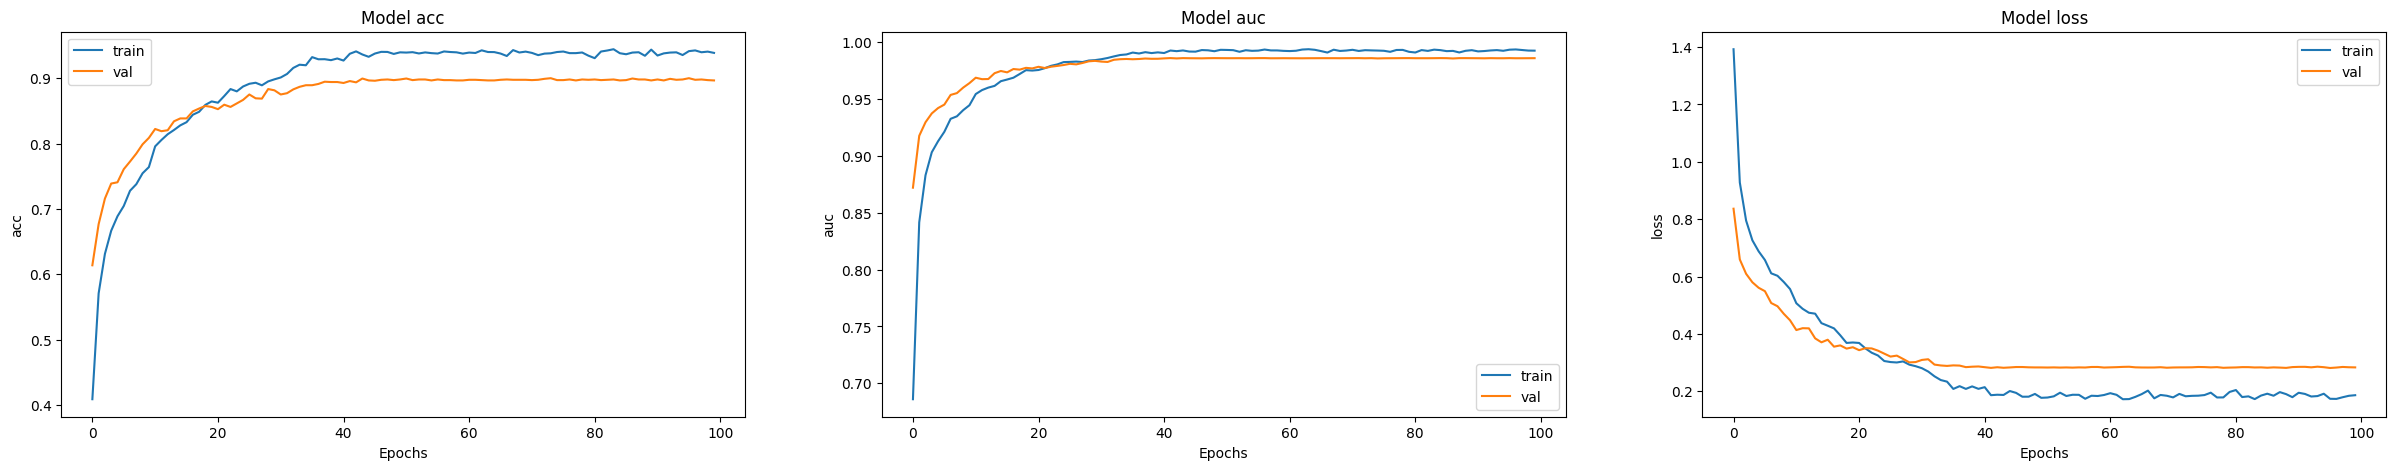

In [20]:
#Plotting the trend of the metrics during training

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

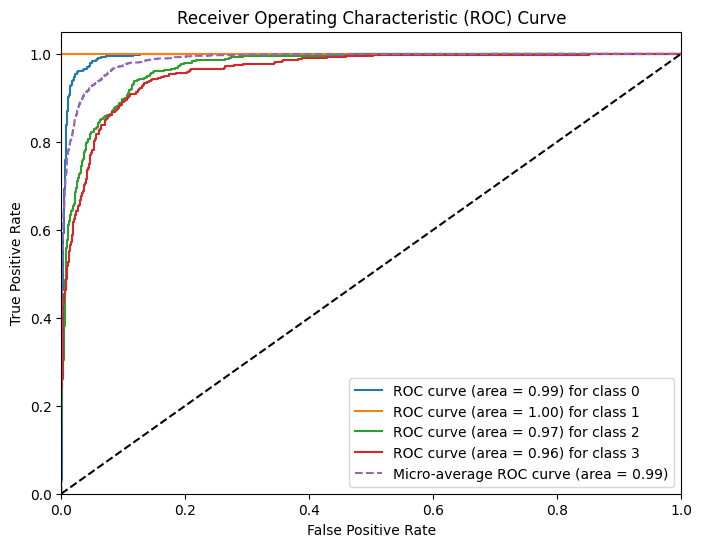

In [38]:
import numpy as np

# Aggregate true labels and predicted probabilities for micro-average
val_labels_aggregated = np.ravel(val_labels)
val_probs_aggregated = np.ravel(val_probs)

# Compute micro-average ROC curve and ROC area
fpr_micro, tpr_micro, _ = roc_curve(val_labels_aggregated, val_probs_aggregated)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot ROC curve for each class and micro-average
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %d' % (roc_auc[i], i))
plt.plot(fpr_micro, tpr_micro, label='Micro-average ROC curve (area = %0.2f)' % roc_auc_micro, linestyle='--')

plt.plot([0, 1], [0, 1], 'k--')  # Plot diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [21]:
#Evaluating the model on the data

#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels)
test_scores = custom_inception_model.evaluate(test_data, test_labels)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 45s 560ms/step - loss: 0.2596 - acc: 0.9031 - auc: 0.9874 - f1_score: 0.9032
Testing Accuracy: 90.31%


In [31]:
#Predicting the test data

pred_labels = custom_inception_model.predict(test_data)

80/80 [==============================] - 49s 594ms/step


In [32]:
#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.94      0.96      0.95       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.87      0.82      0.84       662
ModerateDemented       0.81      0.83      0.82       624

       micro avg       0.90      0.90      0.90      2560
       macro avg       0.90      0.90      0.90      2560
    weighted avg       0.90      0.90      0.90      2560
     samples avg       0.90      0.90      0.90      2560



In [ ]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= CLASSES,
                yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#Printing some other classification metrics

print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

In [26]:
#Saving the model for future use

custom_inception_model_dir = work_dir + "alzheimer_inception_cnn_model"
custom_inception_model.save(custom_inception_model_dir, save_format='h5')
os.listdir(work_dir)

['alzheimer_inception_cnn_model',
 'MildDemented',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [29]:
pretrained_model = tf.keras.models.load_model(custom_inception_model_dir)

#Check its architecture
plot_model(pretrained_model, to_file=work_dir + "model_plot.png", show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
custom_inception_model.save("models/inceptionv3.h5")

### Using a custom CNN model for the task

**Please check out the notebook here: 
[Custom CNN Model Notebook](https://www.kaggle.com/vishakansubramanian/alzheimer-s-disease-classification-notebook)**

In [ ]:
import tensorflow as tf
model2 = tf.keras.models.load_model('models/inceptionv3.h5')


In [12]:

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "AD_data/3-splitted_ADNI(6400)/Alzheimer_s Dataset/test/",
    image_size=IMAGE_SIZE,
    batch_size=32,
)
def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 1279 files belonging to 4 classes.


In [21]:

test_ds2 = tf.keras.preprocessing.image_dataset_from_directory(
    "AD_data/2-OASIS(9488)/input/",
    image_size=IMAGE_SIZE,
    batch_size=32,
)
def one_hot_label(image, label):
    label = tf.one_hot(label, 4)
    return image, label
AUTOTUNE = tf.data.experimental.AUTOTUNE

test_ds2 = test_ds2.map(one_hot_label, num_parallel_calls=AUTOTUNE)

test_ds2 = test_ds2.cache().prefetch(buffer_size=AUTOTUNE)


Found 9488 files belonging to 4 classes.


In [23]:


#train_scores = model.evaluate(train_data, train_labels)
#val_scores = model.evaluate(val_data, val_labels) but its the same modellllllllllllllllllllllllllllllllllllllllll and the same data !!!!!!!!!!!1
test_scores = model2.evaluate(test_ds)

#print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
#print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

297/297 [==============================] - 172s 579ms/step - loss: 220.5367 - acc: 0.3150 - auc: 0.5433 - f1_score: 0.1223
Testing Accuracy: 31.50%


In [22]:
# Assuming you have test images and labels
# Evaluate the loaded model on the test dataset
test_loss, test_accuracy = model2.evaluate(test_ds2)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

297/297 [==============================] - 189s 623ms/step - loss: 220.5366 - acc: 0.3150 - auc: 0.5433 - f1_score: 0.1223


ValueError: too many values to unpack (expected 2)

In [18]:
from tensorflow.keras.preprocessing import image
import numpy as np
# Define the path to the image you want to classify
image_path = 'AD_data/ad.jpg'

# Load and preprocess the image
img_height, img_width = 176, 176 # Example dimensions, replace with your actual image dimensions
img = image.load_img(image_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values to [0, 1]

# Perform inference
predictions = model2.predict(img_array)

# Define class names
class_names = ['Mild_Dementia', 'Moderate_Dementia', 'Non_Dementia', 'Very_Mild_Dementia']

# Convert the predicted probabilities to class labels
predicted_class_index = np.argmax(predictions[0])
predicted_class_label = class_names[predicted_class_index]

# Print the predicted class label and class name
print("Predicted class label:", predicted_class_label)
print("Predicted class name:", class_names[predicted_class_index])

1/1 [==============================] - 0s 29ms/step
Predicted class label: Very_Mild_Dementia
Predicted class name: Very_Mild_Dementia


In [20]:
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
model = tf.keras.models.load_model('models/inceptionv3.h5', custom_objects={})



In [22]:
# Assuming you have already trained your model and loaded it as `model`

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data, test_labels)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


40/40 [==============================] - 17s 416ms/step - loss: 0.3534 - acc: 0.8648 - auc: 0.9788 - f1_score: 0.8757


ValueError: too many values to unpack (expected 2)

In [24]:
from sklearn.metrics import precision_score, recall_score, fbeta_score

# Assuming you have already trained your model and loaded it as `model`

# Make predictions on the test data
predictions = model.predict(test_data)

# Convert predictions to binary labels (0 or 1)
binary_predictions = (predictions > 0.5).astype('int32')
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F2-score
precision, recall, f2_score, _ = precision_recall_fscore_support(test_labels, binary_predictions, average='micro')

# Print the computed metrics
print("Precision:", precision)
print("Recall:", recall)
print("F2 Score:", f2_score)


40/40 [==============================] - 17s 417ms/step
Precision: 0.873116574147502
Recall: 0.86015625
F2 Score: 0.8665879574970484


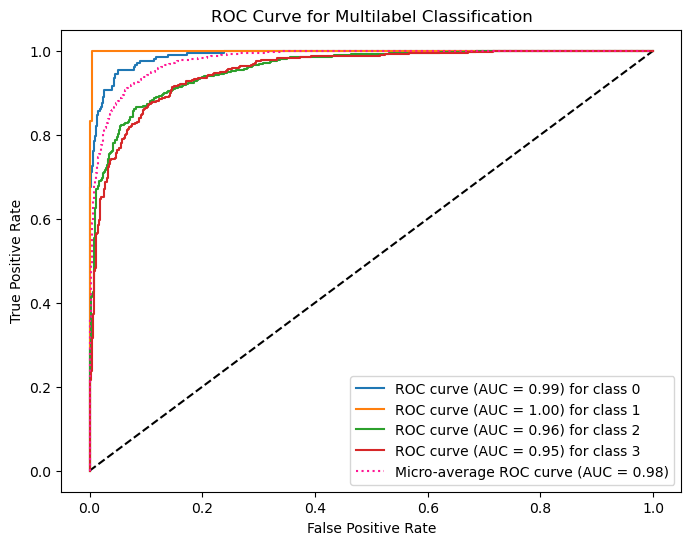

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
auc = {}
n_classes = test_labels.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], predictions[:, i])
    auc[i] = roc_auc_score(test_labels[:, i], predictions[:, i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels.ravel(), predictions.ravel())
auc["micro"] = roc_auc_score(test_labels, predictions, average="micro")

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], 'k--')
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (AUC = {auc[i]:.2f}) for class {i}')
plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {auc["micro"]:.2f})', color='deeppink', linestyle=':')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multilabel Classification')
plt.legend()
plt.show()


In [37]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Convert one-hot encoded test labels to class indices
true_classes = np.argmax(test_labels, axis=1)

# Convert predictions from probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)



Confusion Matrix:
[[174   0   7  20]
 [  0   5   0   1]
 [ 17   0 561  65]
 [  4   0  59 367]]


128/128 [==============================] - 54s 424ms/step


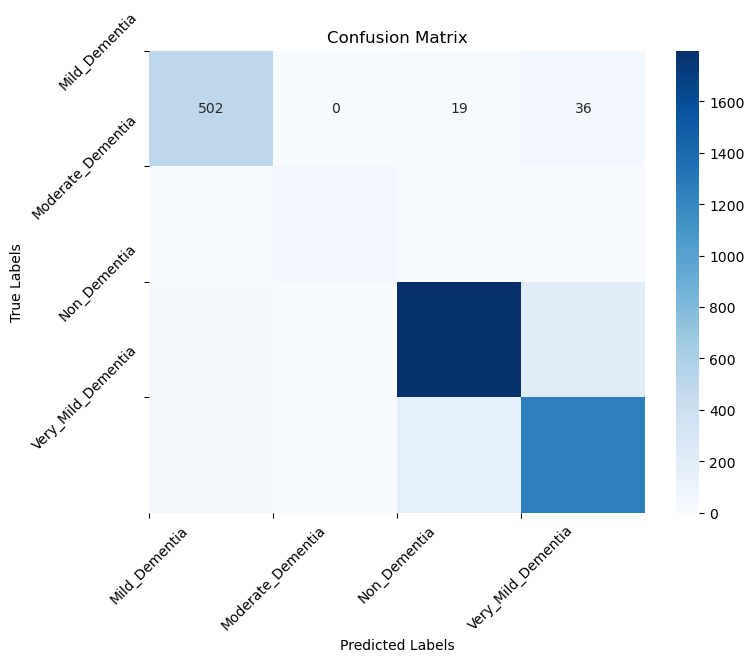

In [44]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your training labels and predictions ready
train_predictions = model.predict(train_data)  # Assuming you already have 'model' trained
true_classes = np.argmax(train_labels, axis=1)  # Convert one-hot encoded labels to class indices
predicted_classes = np.argmax(train_predictions, axis=1)  # Convert probabilities to class indices
class_names = ['Mild_Dementia', 'Moderate_Dementia', 'Non_Dementia', 'Very_Mild_Dementia']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Force display all ticks
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.show()


In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have your test labels and predictions ready
true_classes = true_labels  # Replace true_labels with your actual test labels
predicted_classes = predicted_labels  # Replace predicted_labels with your actual predicted labels
class_names = ['Mild_Dementia', 'Moderate_Dementia', 'Non_Dementia', 'Very_Mild_Dementia']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


NameError: name 'true_labels' is not defined